# PCA , Logistic Regressions  - 1-June-2017
----------------------------
## Summary
1. PCA -  distributions by Activity Subcategory
2. Logistic regression using different number of principal components 
3. Regressions excluding running and jumpling samples

-----------------------------------------------------------

#### Imports 

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn import neighbors

In [3]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

#### Helper functions

In [4]:
def get_data(data_dict, data_id):
    data_name = data_dict.get_value(data_id,'name')
    file_name = data_dict.get_value(data_id,'file')
    df = pd.read_csv(file_name, index_col = 0)
    data = df.iloc[:,1:]
    target = df.fall
    return data_name, data, target

In [5]:
# normalises train data set as (X - mean / stdev) and applies the same scaling to test dataset 
def train_test_normalise(x_train, x_test):
    mean = x_train.mean().T
    std = x_train.std().T
    return ((x_train - mean)/std,(x_test - mean)/std) 

In [6]:
# balance data by duplicating falls
def balance_data_by_duplicating(X, y, num_copies = 1): 
    dd = X.copy(deep=True)
    dd['fall'] = y
    falls_data = dd[dd.fall == 1]
    for i in range(0,num_copies):
        dd = dd.append(falls_data)
    #X_new = dd.iloc[:,1:]
    y_new = dd['fall']
    dd = dd.drop('fall',axis = 1)
    return dd, y_new  

In [7]:
# returns labelled model coefficients 
def model_coefficients(clf, features):
    model_coeff = pd.DataFrame(clf.coef_,columns=features, index = ['value']).T
    model_coeff['abs_value'] = abs(model_coeff.value)
    model_coeff = model_coeff.sort_values('abs_value', ascending = False)
    return model_coeff

In [8]:
def model_metrics(clf, X_train, y_train, X_test, y_test, clf_name='', data_name='', info=''):
    result = pd.DataFrame({'classifier': clf_name,
                           'data_set': data_name,
                           'num_feat': X_train.shape[1],  
                           'info': info,
                           'train_accuracy': metrics.accuracy_score(y_train, clf.predict(X_train)), 
                           'train_precision': metrics.precision_score(y_train, clf.predict(X_train)), 
                           'train_recall': metrics.recall_score(y_train, clf.predict(X_train)),
                           'test_accuracy': metrics.accuracy_score(y_test, clf.predict(X_test)), 
                           'test_precision': metrics.precision_score(y_test, clf.predict(X_test)), 
                           'test_recall': metrics.recall_score(y_test, clf.predict(X_test)),
                          },
                          index = [0])
    columns = ['classifier','data_set','num_feat','test_accuracy','test_precision','test_recall',
              'train_accuracy','train_precision','train_recall','info']
    result = result[columns]
    return result                                                                   

#### Read in data dictionary for available datasets

In [9]:
data_dict = pd.read_csv('data/data_dict.csv', index_col = 0)
test_dict = pd.read_csv('data/test_dict.csv')
test_dict = test_dict.set_index('test_id')
data_dict

,name,desc,num_features,file,normalise
id,,,,,
1,magn_stats,Summary statistics on acceleration magnitude,8,data/magn_stats.csv,1
2,triax_stats,Summary statistics on triaxial acceleration,24,data/triax_stats.csv,1
3,magn_ts,Time series of acceleration magnitude,51,data/magn_ts.csv,0
4,triax_ts,Time series of triaxial accelaration - raw data,153,data/triax_ts.csv,0


--------------------
## PCA using timeseries of acceleration magnitude

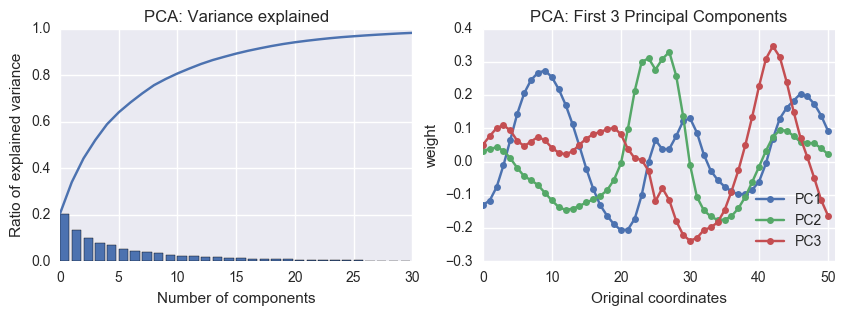

In [10]:
# PCA using timeseries of acceleration magnitude
data_name, data, target = get_data(data_dict,data_id = 3)
pca = PCA()
pca.fit(data)
var_explained = pca.explained_variance_ratio_

# plot results
fig, (ax1,ax2) = plt.subplots(1,2, figsize = [10,3])
# plot explained variance
x = range(0, len(var_explained))
ax1.bar(x, var_explained)
ax1.plot(x, np.cumsum(var_explained)) 
ax1.set_title("PCA: Variance explained")
ax1.set_xlabel("Number of components")
ax1.set_ylabel('Ratio of explained variance')
ax1.set_ylim(0,1);
ax1.set_xlim(0,30);

#plot first principal components
n_components = 3
y = pca.components_
for i in range(0,n_components):
    ax2.plot(y[i], marker = 'o', markersize = 5, label = 'PC{0}'.format(i+1) )
ax2.set_title('PCA: First {0} Principal Components'.format(n_components))
ax2.set_xlabel('Original coordinates')
ax2.set_ylabel('weight')
ax2.set_xlim(0,len(var_explained));
ax2.legend(loc="lower right");

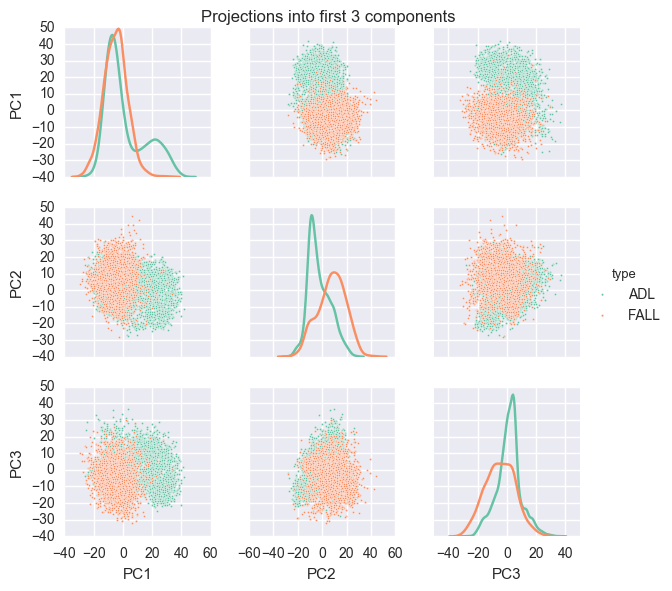

In [11]:
# Project the original data into Principal Components 
pca = PCA(n_components=3)
pca.fit(data)
data_new = pd.DataFrame(pca.transform(data), columns = ['PC1', 'PC2','PC3'])
# add category names
data_new = data_new.join(test_dict[['type','subtype']])
# plot distributions
g = sns.pairplot(data_new, hue="type", diag_kind="kde",size=2,plot_kws={"s": 3},palette='Set2')
plt.subplots_adjust(top=0.95)
g.fig.suptitle('Projections into first 3 components');

### Principal Components by Activity Subcategory

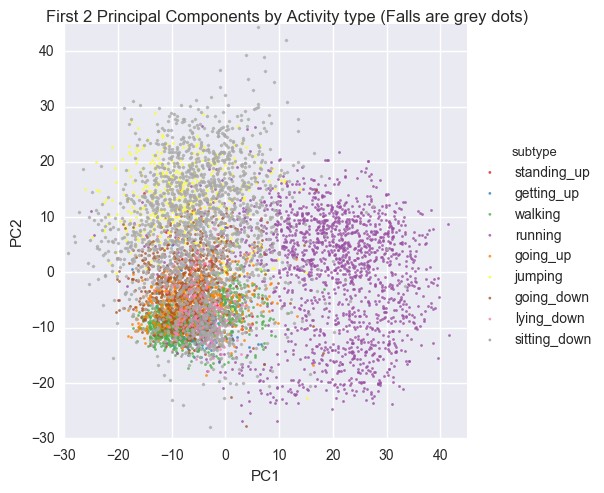

In [12]:
subtypes = data_new.subtype.unique()
g = sns.lmplot(x = 'PC1',y = 'PC2', data = data_new.loc[data_new.type=='ADL',:], hue='subtype', palette = 'Set1',
            fit_reg=False, scatter_kws={"s": 4})
sns.regplot(x = 'PC1',y = 'PC2', data = data_new.loc[data_new.type=='FALL',:], fit_reg=False, marker='x',ax = g.ax,
            color = 'darkgrey',scatter_kws={"s": 2}, )
g.fig.suptitle('First 2 Principal Components by Activity type (Falls are grey dots)');
g.ax.set_xlim(-30,45)
g.ax.set_ylim(-30,45);

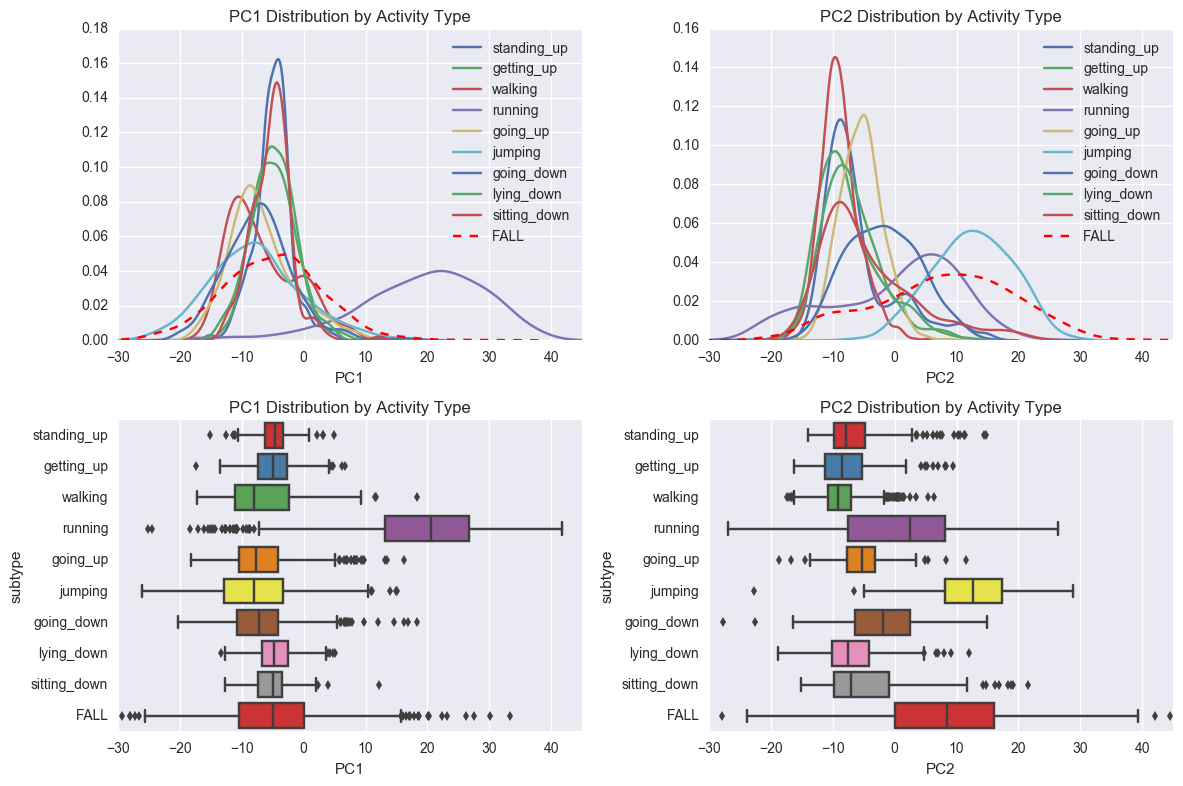

In [13]:
# plot PC1 distribution by subcategories
fig, ax = plt.subplots(2,2, figsize = [12,8])
sns.set_palette(palette='Set1')
# --plot PC1 distribution
for subtype in subtypes[:-1] :
    sns.distplot(data_new.loc[data_new.subtype == subtype,'PC1'],hist=False,label=subtype, ax=ax[0,0])
sns.distplot(data_new.loc[data_new.subtype == 'FALL','PC1'],hist=False,label='FALL',ax=ax[0,0],
             kde_kws={"color": "red",'linestyle':"--"})
sns.boxplot(x = 'PC1', y = 'subtype', data = data_new, palette = 'Set1',ax = ax[1,0])
ax[0,0].set_title('PC1 Distribution by Activity Type')
ax[1,0].set_title('PC1 Distribution by Activity Type')
ax[0,0].set_xlim(-30,45)
ax[1,0].set_xlim(-30,45)
# --plot PC2 distribution
for subtype in subtypes[:-1] :
    sns.distplot(data_new.loc[data_new.subtype == subtype,'PC2'],hist=False,label=subtype, ax=ax[0,1])
sns.distplot(data_new.loc[data_new.subtype == 'FALL','PC2'],hist=False,label='FALL',ax=ax[0,1],
             kde_kws={"color": "red",'linestyle':"--"})
sns.boxplot(x = 'PC2', y = 'subtype', data = data_new, palette = 'Set1',ax = ax[1,1])
ax[0,1].set_title('PC2 Distribution by Activity Type')
ax[1,1].set_title('PC2 Distribution by Activity Type')
ax[0,1].set_xlim(-30,45)
ax[1,1].set_xlim(-30,45)
plt.tight_layout()

-------------
## Logistic regressions using Principal components :  ROC curves

In [14]:
# regularisation params
Cs = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
param_grid = {'C': Cs, 'penalty':['l1','l2']}

,classifier,data_set,num_feat,test_accuracy,test_precision,test_recall,train_accuracy,train_precision,train_recall,info
0,LogRegr,magn_ts PCA: 1 components,1,0.760157,0.582418,0.077035,0.764916,0.593220,0.069238,"{'penalty': 'l2', 'C': 0.001}"
0,LogRegr,magn_ts PCA: 2 components,2,0.808981,0.677570,0.421512,0.802710,0.642072,0.404550,"{'penalty': 'l2', 'C': 0.01}"
0,LogRegr,magn_ts PCA: 3 components,3,0.823236,0.682510,0.521802,0.833611,0.697085,0.544016,"{'penalty': 'l2', 'C': 0.01}"
0,LogRegr,magn_ts PCA: 7 components,7,0.893799,0.829392,0.713663,0.889945,0.809955,0.708210,"{'penalty': 'l2', 'C': 0.01}"
0,LogRegr,magn_ts PCA: 15 components,15,0.907698,0.848780,0.758721,0.912764,0.852298,0.770524,"{'penalty': 'l2', 'C': 0.01}"
0,LogRegr,magn_ts PCA: 26 components,26,0.913756,0.866776,0.765988,0.918945,0.876404,0.771513,"{'penalty': 'l1', 'C': 0.01}"


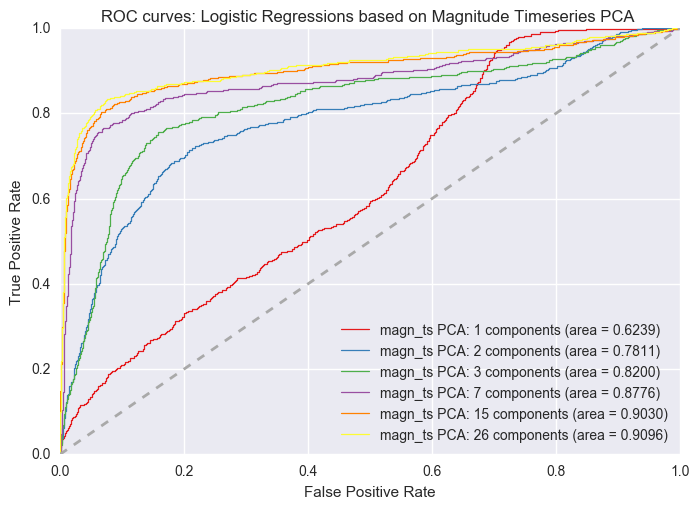

In [15]:
# using magnitude timeseries
data_id = 3
data_name, data, target = get_data(data_dict,data_id)
#split into training and test data
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state = 42, test_size = 0.4)
res_store = pd.DataFrame()
for i in [1,2,3,7,15,26]:
    # perform PCA on Train data
    data_desc = data_name + ' PCA: '+ str(i) + ' components'
    pca = PCA(n_components=i)
    pca.fit(X_train)
    # transform data into PC
    X_train_trans = pca.transform(X_train)
    X_test_trans = pca.transform(X_test)
    # train logistic regression on transformed data
    clf = GridSearchCV(LogisticRegression(), param_grid, cv = 5)
    clf.fit(X_train_trans, y_train)
    y_score = clf.decision_function(X_test_trans)
    # record results
    mm =  model_metrics(clf, X_train_trans, y_train, X_test_trans, y_test, clf_name='LogRegr',data_name=data_desc, info=str(clf.best_params_))
    res_store = pd.concat([res_store, mm])
    # plot ROC curve
    fpr, tpr, _ = metrics.roc_curve(y_test, y_score)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label= data_desc + ' (area = %0.4f)' % roc_auc, lw = 0.9)  
# Decorate plot
plt.plot([0, 1], [0, 1], color='darkgrey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves: Logistic Regressions based on Magnitude Timeseries PCA ')
plt.legend(loc="lower right");  
res_store   

,classifier,data_set,num_feat,test_accuracy,test_precision,test_recall,train_accuracy,train_precision,train_recall,info
0,LogRegr,triax_ts PCA: 8 components,8,0.841055,0.810256,0.459302,0.835512,0.778360,0.441147,"{'penalty': 'l2', 'C': 0.001}"
0,LogRegr,triax_ts PCA: 15 components,15,0.831076,0.884892,0.357558,0.829094,0.878238,0.335312,"{'penalty': 'l2', 'C': 0.01}"
0,LogRegr,triax_ts PCA: 45 components,45,0.830720,0.904943,0.345930,0.832660,0.898701,0.342235,"{'penalty': 'l1', 'C': 0.01}"
0,LogRegr,triax_ts PCA: 80 components,80,0.830364,0.895522,0.348837,0.833135,0.899225,0.344214,"{'penalty': 'l1', 'C': 0.01}"
0,LogRegr,triax_ts PCA: 151 components,151,0.830364,0.895522,0.348837,0.833135,0.899225,0.344214,"{'penalty': 'l1', 'C': 0.01}"


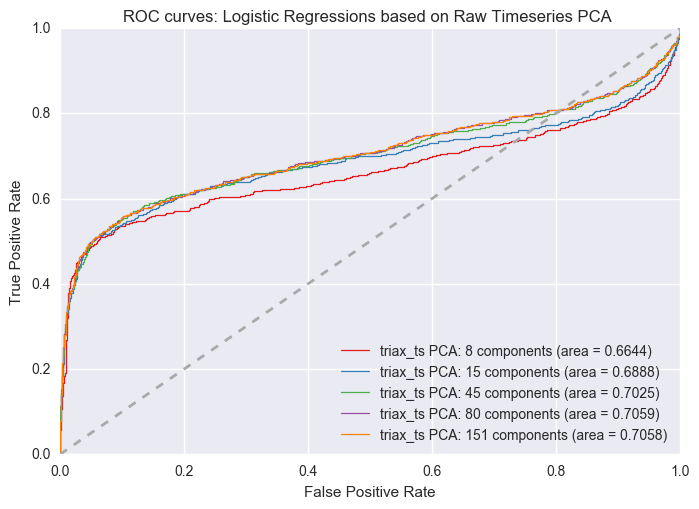

In [16]:
# using raw timeseries
data_id = 4
data_name, data, target = get_data(data_dict,data_id)
#split into training and test data
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state = 42, test_size = 0.4)
res_store_2 = pd.DataFrame()
for i in [8,15,45,80,151]:
    # perform PCA on Train data
    data_desc = data_name + ' PCA: '+ str(i) + ' components'
    pca = PCA(n_components=i)
    pca.fit(X_train)
    # transform data into PC
    X_train_trans = pca.transform(X_train)
    X_test_trans = pca.transform(X_test)
    # train logistic regression on transformed data
    clf = GridSearchCV(LogisticRegression(), param_grid, cv = 5)
    clf.fit(X_train_trans, y_train)
    y_score = clf.decision_function(X_test_trans)
    # record results
    mm =  model_metrics(clf, X_train_trans, y_train, X_test_trans, y_test, clf_name='LogRegr',data_name=data_desc, info=str(clf.best_params_))
    res_store_2 = pd.concat([res_store_2, mm])
    # plot ROC curve
    fpr, tpr, _ = metrics.roc_curve(y_test, y_score)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label= data_desc + ' (area = %0.4f)' % roc_auc, lw = 0.9)  
# Decorate plot
plt.plot([0, 1], [0, 1], color='darkgrey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves: Logistic Regressions based on Raw Timeseries PCA ')
plt.legend(loc="lower right");  
res_store_2  

------------------
## Data sets excluding jumping and running

,classifier,data_set,num_feat,test_accuracy,test_precision,test_recall,train_accuracy,train_precision,train_recall,info
0,LogRegr,magn_stats - Original data,8,0.858874,0.770370,0.604651,0.872593,0.795031,0.633037,"{'penalty': 'l1', 'C': 0.1}"
0,LogRegr,magn_stats - Exc run/jump,8,0.921579,0.926635,0.844477,0.934443,0.930526,0.874382,"{'penalty': 'l1', 'C': 1}"
0,LogRegr,triax_stats - Original data,24,0.942979,0.920382,0.840116,0.956026,0.941239,0.871414,"{'penalty': 'l2', 'C': 1}"
0,LogRegr,triax_stats - Exc run/jump,24,0.939006,0.937020,0.886628,0.957541,0.960499,0.913947,"{'penalty': 'l2', 'C': 1}"
0,LogRegr,magn_ts - Original data,51,0.917320,0.882550,0.764535,0.926789,0.905421,0.776459,"{'penalty': 'l2', 'C': 1}"
0,LogRegr,magn_ts - Exc run/jump,51,0.905177,0.906300,0.815407,0.935122,0.934322,0.872404,"{'penalty': 'l1', 'C': 1}"


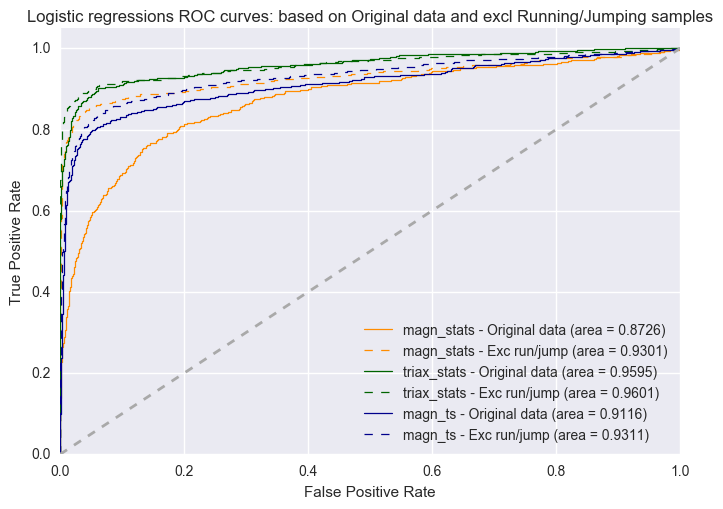

In [17]:
res_store = pd.DataFrame()
colors = ['darkorange', 'darkgreen', 'darkblue']
for data_id in [1,2,3]:
    data_name, data, target = get_data(data_dict,data_id)
    need_normalise = data_dict.get_value(data_id,'normalise') 
    
    #split into training and test and normalise if required
    X_train, X_test, y_train, y_test = train_test_split(data, target, random_state = 42, test_size = 0.4)
    if (need_normalise == 1): 
        X_train, X_test = train_test_normalise(X_train, X_test)
    
    # train classifier on the data as it is ( unbalanced) 
    data_desc = data_name + ' - Original data'
    clf = GridSearchCV(LogisticRegression(), param_grid, cv = 5)
    clf.fit(X_train, y_train)
    y_score = clf.decision_function(X_test)
    #   record results
    mm =  model_metrics(clf, X_train, y_train, X_test, y_test, clf_name='LogRegr',data_name=data_desc, info=str(clf.best_params_))
    res_store = pd.concat([res_store, mm])
    #   plot ROC curve
    fpr, tpr, _ = metrics.roc_curve(y_test, y_score)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label= data_desc + ' (area = %0.4f)' % roc_auc, color = colors[data_id - 1], lw = 0.9)    
    
    # remove running and jumping samples and train classifier 
    data_desc = data_name + ' - Exc run/jump'
    df = X_train.join(test_dict[['activity']])
    df = df[df.activity!='running']
    df = df[df.activity!='jumping']
    X_train_exc = df.drop('activity',axis=1)
    y = pd.DataFrame(y_train)
    df = y.join(test_dict[['activity']])
    df = df[df.activity!='running']
    df = df[df.activity!='jumping']
    y_train_exc = df['fall']
    df = X_test.join(test_dict[['activity']])
    df = df[df.activity!='running']
    df = df[df.activity!='jumping']
    X_test_exc = df.drop('activity',axis=1)
    y = pd.DataFrame(y_test)
    df = y.join(test_dict[['activity']])
    df = df[df.activity!='running']
    df = df[df.activity!='jumping']
    y_test_exc = df['fall']
    
    # train classifier on reduced data set
    clf = GridSearchCV(LogisticRegression(), param_grid, cv = 5)
    clf.fit(X_train_exc, y_train_exc)
    y_score = clf.decision_function(X_test_exc)
    # record results
    mm =  model_metrics(clf, X_train_exc, y_train_exc, X_test_exc, y_test_exc, clf_name='LogRegr', data_name=data_desc, info=str(clf.best_params_))
    res_store = pd.concat([res_store, mm])
    # plot ROC curve
    fpr, tpr, _ = metrics.roc_curve(y_test_exc, y_score)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr,  label= data_desc + ' (area = %0.4f)' % roc_auc, color = colors[data_id - 1],  linestyle='--', lw = 0.9)
# Decorate plot
plt.plot([0, 1], [0, 1], color='darkgrey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic regressions ROC curves: based on Original data and excl Running/Jumping samples')
plt.legend(loc="lower right");  
res_store

In [18]:
res_store

,classifier,data_set,num_feat,test_accuracy,test_precision,test_recall,train_accuracy,train_precision,train_recall,info
0,LogRegr,magn_stats - Original data,8,0.858874,0.770370,0.604651,0.872593,0.795031,0.633037,"{'penalty': 'l1', 'C': 0.1}"
0,LogRegr,magn_stats - Exc run/jump,8,0.921579,0.926635,0.844477,0.934443,0.930526,0.874382,"{'penalty': 'l1', 'C': 1}"
0,LogRegr,triax_stats - Original data,24,0.942979,0.920382,0.840116,0.956026,0.941239,0.871414,"{'penalty': 'l2', 'C': 1}"
0,LogRegr,triax_stats - Exc run/jump,24,0.939006,0.937020,0.886628,0.957541,0.960499,0.913947,"{'penalty': 'l2', 'C': 1}"
0,LogRegr,magn_ts - Original data,51,0.917320,0.882550,0.764535,0.926789,0.905421,0.776459,"{'penalty': 'l2', 'C': 1}"
0,LogRegr,magn_ts - Exc run/jump,51,0.905177,0.906300,0.815407,0.935122,0.934322,0.872404,"{'penalty': 'l1', 'C': 1}"
